In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.src.models import Sequential
from keras.src.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization
from keras.src.layers.pooling.max_pooling2d import MaxPooling2D
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
train_df = pd.read_csv("dataset/sign_mnist_train.csv")
test_df = pd.read_csv("dataset/sign_mnist_test.csv")
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

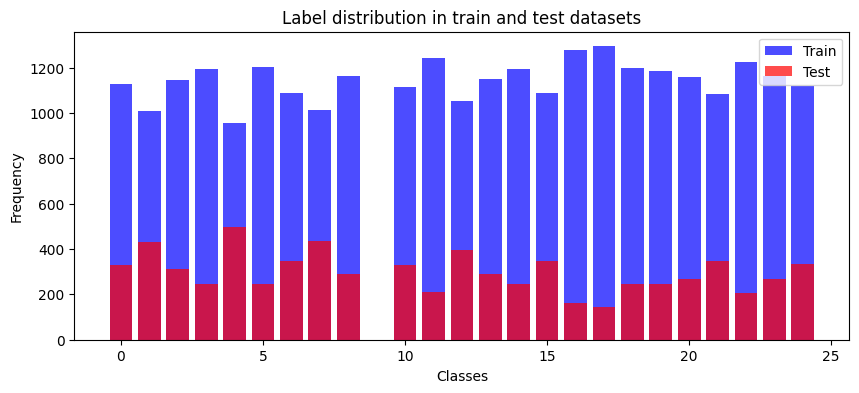

In [9]:
# **Data Balance Checking**
train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()

plt.figure(figsize=(10, 4))
plt.bar(train_label_counts.index, train_label_counts.values, color='blue', alpha=0.7, label='Train')
plt.bar(test_label_counts.index, test_label_counts.values, color='red', alpha=0.7, label='Test')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Label distribution in train and test datasets')
plt.legend()
plt.show()

In [ ]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

x_train = train_df.values
x_test = test_df.values

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1,factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


In [ ]:
model = Sequential()

model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128), epochs = 20, validation_data = (x_test, y_test), class_weight=class_weights, callbacks = [learning_rate_reduction, early_stopping])

In [ ]:
model.save('models/smnist.keras')

In [ ]:
# Evaluation

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
# Classification report
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(classification_report(y_true, y_pred_classes))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
             xticklabels=label_binarizer.classes_, 
             yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()